# Comparación de palabras iguales en poemas con emociones diferentes.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from nltk.tokenize import word_tokenize
import nltk
import we_to_signal as wes

[nltk_data] Downloading package punkt to /home/ulises/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ulises/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Con los poemas separados, los metemos en un diccionario de dataframes
import os

data_path = "data/"
emotion_list = ["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"]

json_files = sorted([pos_json for pos_json in os.listdir(data_path) if pos_json.endswith('.json')])
json_files.remove('Poems.json')
json_files.remove('missing.json')

em_poems = {}
for e in emotion_list:
    f = open(data_path+e+".json")
    df_ = pd.DataFrame(json.load(f))
    em_poems[e] = df_
em_poems["anger"]

,poem,id
0,i do know this it's nothing i can hold\nlast ...,10
1,the fear o' hell's a hangman's whip\nto haud t...,18
2,but since i laid a hand thereon\nand found a h...,88
3,falsely i pointed to sum in text\nseriously he...,99
4,i'll wear my jealous reflection\njuice of lemo...,125
...,...,...
2461,new snow on a leaf\nlike granulated sugar\nmak...,93124
2462,new earth and old earth\na trio of guardians\n...,93138
2463,destructions despair\nconstructions hope toge...,93217
2464,hot dry summers will\nbake paint right off the...,93226


In [3]:
#Carga de embeddings
from gensim.models import Word2Vec
from gensim.models import FastText

emotion_list = ["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"]

poems_w2v = {}
poems_fst = {}

for e in emotion_list:
    w2v_lines = Word2Vec.load("embeddings_poems/w2v_model_"+e)
    fst_lines = FastText.load("embeddings_poems/fst_model_"+e)
    poems_w2v[e] = w2v_lines
    poems_fst[e] = fst_lines

In [4]:
emotion_a = "anger"
emotion_b = "anticipation"

mw2v_a = poems_w2v[emotion_a]
mfst_a = poems_fst[emotion_a]

mw2v_b = poems_w2v[emotion_b]
mfst_b = poems_fst[emotion_b]

In [5]:
def common_word(model_a,model_b)->list:
    """
    Create a list of common word in two gensim models.

    Parameters
    -------------
    model_a: Gensim model (fst or w2v).
    model_b: Gensim model (fst or w2v).

    Returns
    --------------
    list: List with common words between the models.
    """
    model_a_dict = model_a.wv.key_to_index
    model_b_dict = model_b.wv.key_to_index

    common_words = []
    for key in list(model_a_dict.keys()):
        if key in model_b_dict:
            common_words.append(key)
    
    return common_words

common_words_w2v = common_word(mw2v_a,mw2v_b)
common_words_fst = common_word(mfst_a,mfst_b)

In [6]:
def get_vectors(words:list,model)->list:
    """
    Calculate the embeddings of a list of strings gived a model.

    Parameters
    ------------
    words: List with strings.
    model: gensim model(fst or w2v)
    
    Returns
    ------------
    list: List with tuples of [word,vector].
    """

    vectors = []
    for word in words:
        vectors.append((word,model.wv.get_vector(word)))
    return vectors

In [7]:
def build_words_vectors_data(common_words:list,model_a,model_b)->pd.DataFrame:
    """
    Creates a Dataframe with columns [words, embbeding_model_a, embbeding_model_b]
    
    Parameters
    ------------
    common_words: list with common word between models.
    model_a: gensim model (fastext or w2v).
    model_b: gensim model (fastext or w2v).
    """

    data = {}
    data["words"] = common_words.copy()
    data["embbeding_model_a"] = []
    data["embbeding_model_b"] = []

    for word in common_words:
        data["embbeding_model_a"].append(model_a.wv.get_vector(word,norm=True))
        data["embbeding_model_b"].append(model_b.wv.get_vector(word,norm=True))

    return pd.DataFrame(data)

In [8]:
data_w2v = build_words_vectors_data(common_words_w2v,mw2v_a,mw2v_b)
data_fst = build_words_vectors_data(common_words_fst,mfst_a,mfst_b)

display(data_w2v)
display(data_fst)

,words,embbeding_model_a,embbeding_model_b
0,the,"[-0.074571356, 0.09888577, -0.035351947, 0.058...","[-0.12992264, 0.09067258, 0.0016633858, 0.0660..."
1,and,"[-0.076016836, 0.09836932, -0.0359653, 0.05484...","[-0.09529541, 0.14158711, 0.007732343, -0.0349..."
2,of,"[-0.07567521, 0.09813196, -0.037018374, 0.0551...","[-0.103375435, 0.124761075, -0.009955226, 0.01..."
3,a,"[-0.07517576, 0.09953175, -0.03721849, 0.05452...","[-0.10672734, 0.12793517, 0.005556323, 0.00644..."
4,to,"[-0.0747832, 0.09769986, -0.036672354, 0.05156...","[-0.041993607, 0.20082001, 0.0009315059, -0.09..."
...,...,...,...
8265,martyrs,"[-0.11708717, 0.18000051, -0.07979874, 0.10236...","[-0.09172351, 0.028397692, -0.036259986, -0.01..."
8266,elation,"[-0.056189828, 0.09017971, 0.060131565, 0.1171...","[0.043908708, 0.030624766, -0.10485483, 0.0380..."
8267,afternoons,"[0.060429826, -0.12160156, 0.07337983, -0.1498...","[-0.10714079, 0.15676244, 0.06014968, 0.108518..."
8268,gibberish,"[-0.009315444, 0.05983702, -0.09838189, 0.1613...","[-0.022979211, 0.18154301, -0.033790972, -0.00..."


,words,embbeding_model_a,embbeding_model_b
0,the,"[0.05892307, 0.038402352, -0.075489864, 0.0635...","[0.043330193, -0.010277707, -0.16763657, -0.00..."
1,and,"[0.059186235, 0.039017975, -0.073899955, 0.064...","[0.013457333, 0.028681222, -0.09165401, -0.027..."
2,of,"[0.061216712, 0.039325263, -0.075887546, 0.063...","[-0.009552455, 0.03292888, -0.0690358, -0.0304..."
3,a,"[0.059903935, 0.038734823, -0.07522733, 0.0629...","[0.03983606, 0.010796906, -0.09718523, -0.0059..."
4,to,"[0.060684998, 0.03858779, -0.07509665, 0.06213...","[0.074966714, 0.01745066, -0.041270588, 0.0064..."
...,...,...,...
1755,fortunes,"[0.060194585, 0.038032826, -0.07509847, 0.0634...","[0.047516268, 0.010357625, -0.06097739, 0.0037..."
1756,release,"[0.061862584, 0.03776, -0.07397126, 0.06235046...","[0.06364246, 0.003003505, -0.052978072, 0.0139..."
1757,decide,"[0.059682563, 0.039320666, -0.07605457, 0.0621...","[0.054955315, 0.008287174, -0.05922585, 0.0076..."
1758,bridges,"[0.060322605, 0.038319036, -0.074086666, 0.063...","[0.03656169, 0.013152264, -0.066844985, -0.003..."


In [9]:
word = "bring"

word_data = data_w2v[data_w2v["words"]==word]
word_data

,words,embbeding_model_a,embbeding_model_b
339,bring,"[-0.0688656, 0.09416714, -0.03821187, 0.053954...","[-0.05977244, 0.16778417, 0.009542436, -0.0438..."


In [10]:
print(word_data["embbeding_model_a"].values)

[array([-0.0688656 ,  0.09416714, -0.03821187,  0.05395499, -0.01844637,
        -0.2211572 ,  0.07139511,  0.28029686, -0.08197512, -0.11862894,
        -0.03529203, -0.1844964 , -0.04797777,  0.1167135 ,  0.08020385,
        -0.06601369,  0.08363637, -0.07533801,  0.00131319, -0.1951293 ,
         0.1019508 ,  0.06257318,  0.11337823, -0.07108132,  0.00257333,
        -0.01600572, -0.10341936, -0.05314986, -0.14204891,  0.05522308,
         0.16569097, -0.03880035,  0.03558872, -0.11911778, -0.06649421,
         0.10201389,  0.05073204, -0.04951679, -0.10054959, -0.22217542,
         0.01045941, -0.09135779, -0.051673  ,  0.03244301,  0.10582011,
        -0.06917658, -0.1120397 , -0.04529528,  0.06246192,  0.07548869,
         0.04870709, -0.07880032, -0.01240519, -0.04002517, -0.04369382,
         0.05379791,  0.04440226, -0.03455228, -0.11280337,  0.01228787,
         0.08759329, -0.03583346,  0.00696939, -0.02195072, -0.10176867,
         0.19567388,  0.01146567,  0.15209161, -0.2

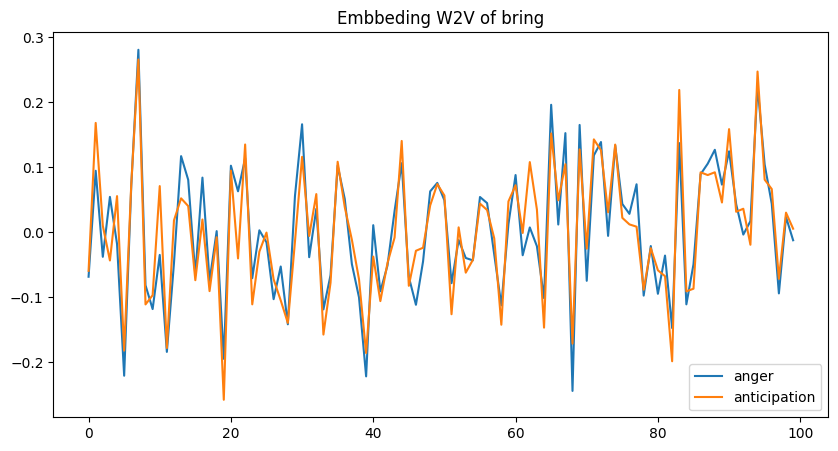

In [11]:
legend = [emotion_a,emotion_b]
plt.figure(figsize=(10,5))
plt.title("Embbeding W2V of "+word)
plt.plot(word_data["embbeding_model_a"].values[0])
plt.plot(word_data["embbeding_model_b"].values[0])
plt.legend(legend)

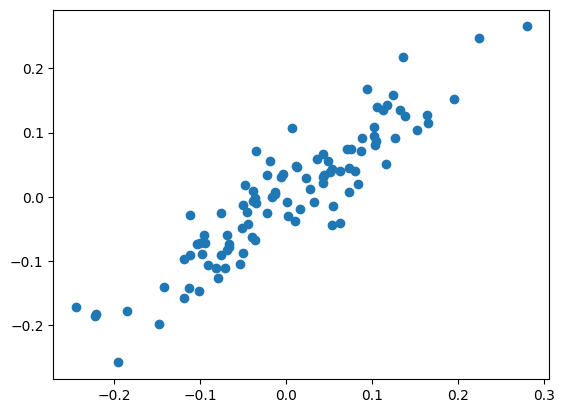

In [12]:
plt.scatter(word_data["embbeding_model_a"].values[0],word_data["embbeding_model_b"].values[0])

In [13]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr

display(spearmanr(word_data["embbeding_model_a"].values[0],word_data["embbeding_model_b"].values[0]))
display(pearsonr(word_data["embbeding_model_a"].values[0],word_data["embbeding_model_b"].values[0]))

SignificanceResult(statistic=0.9093309330933094, pvalue=4.209882109466041e-39)

PearsonRResult(statistic=0.9157850532955004, pvalue=1.323292927356247e-40)

In [14]:
set_ = set()
for emotion in emotion_list:
    fst = set(poems_fst[emotion].wv.key_to_index.keys())
    w2v = set(poems_fst[emotion].wv.key_to_index.keys())
    intersection = fst & w2v
    if not set_:
        set_ = set_.union(intersection)
    else:
        set_ = set_.intersection(intersection)

display(len(set_))
display(set_)

677

{'a',
 'about',
 'above',
 'across',
 'act',
 'after',
 'again',
 'against',
 'age',
 'ago',
 'ah',
 'air',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'always',
 'am',
 'among',
 'amp',
 'an',
 'ancient',
 'and',
 'angels',
 'another',
 'answer',
 'any',
 'are',
 'arms',
 'around',
 'as',
 'ask',
 'at',
 'away',
 'b',
 'back',
 'bare',
 'be',
 'bear',
 'beauty',
 'because',
 'become',
 'bed',
 'been',
 'before',
 'begin',
 'behind',
 'behold',
 'being',
 'beneath',
 'bent',
 'beside',
 'best',
 'better',
 'between',
 'beyond',
 'big',
 'bird',
 'birds',
 'bit',
 'black',
 'blind',
 'blood',
 'blow',
 'blue',
 'body',
 'book',
 'books',
 'born',
 'both',
 'bound',
 'bow',
 'brain',
 'branches',
 'bread',
 'break',
 'breast',
 'breath',
 'breathe',
 'breeze',
 'bright',
 'bring',
 'brought',
 'brown',
 'burn',
 'burst',
 'but',
 'by',
 'call',
 'called',
 'came',
 'can',
 'cant',
 'care',
 'cat',
 'chair',
 'cheek',
 'children',
 'city',
 'clay',
 'clear',
 'close',
 'c

In [15]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
set_ = set_ - stop_words
set_

{'across',
 'act',
 'age',
 'ago',
 'ah',
 'air',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'always',
 'among',
 'amp',
 'ancient',
 'angels',
 'another',
 'answer',
 'arms',
 'around',
 'ask',
 'away',
 'b',
 'back',
 'bare',
 'bear',
 'beauty',
 'become',
 'bed',
 'begin',
 'behind',
 'behold',
 'beneath',
 'bent',
 'beside',
 'best',
 'better',
 'beyond',
 'big',
 'bird',
 'birds',
 'bit',
 'black',
 'blind',
 'blood',
 'blow',
 'blue',
 'body',
 'book',
 'books',
 'born',
 'bound',
 'bow',
 'brain',
 'branches',
 'bread',
 'break',
 'breast',
 'breath',
 'breathe',
 'breeze',
 'bright',
 'bring',
 'brought',
 'brown',
 'burn',
 'burst',
 'call',
 'called',
 'came',
 'cant',
 'care',
 'cat',
 'chair',
 'cheek',
 'children',
 'city',
 'clay',
 'clear',
 'close',
 'clouds',
 'cold',
 'color',
 'come',
 'comes',
 'cool',
 'could',
 'country',
 'course',
 'cried',
 'cries',
 'cry',
 'cup',
 'cut',
 'dark',
 'day',
 'days',
 'dead',
 'dear',
 'death',
 'deep',
 'died',
 'dim',

In [16]:
from collections import Counter

def get_word_freq(dataframe:pd.DataFrame,col:str,emotion_list:list):
    """
    Calculates for Counter model of each emotion text corpus.

    Parameters
    ------------
    dataframe: pandas Dataframe with documents.
    col:str name of the column where the documents are.
    emotion_list: list with emotions

    Returns
    -----------
    dict:
        dictionary with keys(emotions_list) an each key with his self Counter model.
    """
    freq_dict = {}
    for emotion in emotion_list:
        tokens = dataframe[emotion][col].apply(lambda x: [token for token in word_tokenize(x)])
        l1 = tokens.values.tolist()
        l2 = [w for l in l1 for w in l ]
        freq_dict[emotion] = Counter(l2)
    return freq_dict

In [17]:
def text_clean(sent):
    import re
    from unidecode import unidecode
    import unicodedata as ud

    d = {ord('\N{combining acute accent}'):None}
    sent = ud.normalize('NFD',sent).translate(d)
    sent = re.sub(r"[^\w .,;?!\n]+", "", sent)
    sent = re.sub(r"[^\w .,;?!]", " ", sent)
    sent = re.sub(r"[^\w .,]", ".", sent)
    sent = re.sub(r"[^\w ]", "", sent)
    sent = re.sub(r"[0-9]", "", sent)
    sent = re.sub(r"[α-ωςϑϕϜϝϞϠϰϱ]", "", sent)
    sent = re.sub(r"[ΓΔΕΖΗΘΙΚΛΜΝΞΟΠΡΣΤΥΦΧΨΩ]", "", sent)
    sent = re.sub(r"[A-Z]{2}", "", sent)
    return sent

In [18]:
em_poem_c = dict()

for emotion in emotion_list:
    em_poem_c[emotion] = em_poems[emotion].copy()

for emotion in emotion_list:
    em_poem_c[emotion]["poems_clean"] = em_poem_c[emotion]["poem"].apply(text_clean)

freq_dict = get_word_freq(em_poem_c,"poems_clean",emotion_list)
freq_dict

{'anger': Counter({'the': 5646,
          'and': 3318,
          'of': 2235,
          'a': 1857,
          'to': 1720,
          'in': 1642,
          'i': 1193,
          'that': 872,
          'with': 815,
          'is': 719,
          'his': 688,
          'my': 668,
          'on': 597,
          'for': 596,
          'you': 590,
          'he': 563,
          'it': 557,
          'not': 549,
          'but': 513,
          'words': 481,
          'all': 476,
          'as': 443,
          'at': 410,
          'from': 397,
          'was': 394,
          'me': 383,
          'they': 381,
          'their': 356,
          'by': 349,
          'like': 342,
          'are': 338,
          'your': 336,
          'or': 330,
          'be': 323,
          'her': 323,
          'we': 310,
          'so': 304,
          'this': 290,
          'when': 286,
          'an': 283,
          'no': 268,
          'what': 257,
          'have': 249,
          'will': 232,
          'one': 227,
 

In [19]:
#Creamos el dataframe de las palabras con su correlacion pearson
from itertools import combinations

emotion_combinations = list(combinations(emotion_list,2))

words_embbed_info = {}
words_embbed_info["words"] = list(set_)

for emotion in emotion_list:
    words_embbed_info["f_"+emotion] = []

for comb in emotion_combinations:
    words_embbed_info["P_"+str(comb)] = []

for word in set_:
    #Añadimos la frecuencia por cada emoción
    for emotion in emotion_list:
        words_embbed_info["f_"+emotion].append(freq_dict[emotion][word])

    #Calculamos la correlacion pearson para cada par de emociones.    
    for comb in emotion_combinations:
        emotion_a = comb[0]
        emotion_b = comb[1]

        words_embbed_info["P_"+str(comb)].append(pearsonr(poems_w2v[emotion_a].wv.get_vector(word,norm=True),poems_w2v[emotion_b].wv.get_vector(word,norm=True)))
    
words_embbed_w2v_info = pd.DataFrame(words_embbed_info)
words_embbed_w2v_info

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,angels,6,42,7,48,85,40,13,71,"(0.8988065489034235, 7.055847275084517e-37)",...,"(0.8607215739963445, 1.712170099770417e-30)","(0.8899573932390307, 3.4462599595213175e-35)","(0.8894991071073067, 4.176825268491561e-35)","(0.8761741833431879, 7.933365490799138e-33)","(0.8833495702950374, 5.092356819298463e-34)","(0.891536961090628, 1.7648150349739527e-35)","(0.8874175039252394, 9.89761761022895e-35)","(0.8941690923196585, 5.652613398822437e-36)","(0.8981365572755738, 9.589284261742696e-37)","(0.8879609015390748, 7.914714102775719e-35)"
1,mine,36,137,11,77,231,133,15,170,"(0.9111223244564031, 1.654762781412378e-39)",...,"(0.8716597879205468, 4.0964061166244636e-32)","(0.874659424726533, 1.385942570257822e-32)","(0.8808075854321814, 1.3745109392796137e-33)","(0.8484669407827862, 7.826093912148501e-29)","(0.8436217401270576, 3.2351231436394827e-28)","(0.8383083853525553, 1.4527286073063611e-27)","(0.843827926707233, 3.048529635798323e-28)","(0.8834806864147625, 4.835090590661267e-34)","(0.8705697815879468, 6.032664604530273e-32)","(0.8707329710438524, 5.694274556714732e-32)"
2,sweet,14,338,11,43,633,118,46,302,"(0.9058415131055247, 2.458037919726889e-38)",...,"(0.8695111459423607, 8.756405719679873e-32)","(0.8913547453031821, 1.9074641399980725e-35)","(0.8849483606972746, 2.694807350042054e-34)","(0.8789966630046964, 2.750473230196147e-33)","(0.8796381677271099, 2.153988826091658e-33)","(0.892690338071617, 1.0755223392839649e-35)","(0.8917606229379785, 1.6039150482204168e-35)","(0.9050905548107455, 3.561242286535291e-38)","(0.9058302165841691, 2.471841740721094e-38)","(0.8980971547594374, 9.763219779436225e-37)"
3,feet,36,128,26,90,162,179,16,177,"(0.904142457208129, 5.662112987758475e-38)",...,"(0.8318099368653717, 8.484734876783194e-27)","(0.8832420617602873, 5.313237134872423e-34)","(0.8926296813137091, 1.104057186705013e-35)","(0.8690329110110955, 1.0350546936976631e-31)","(0.8781142166748813, 3.841188665749821e-33)","(0.8833467143746524, 5.098106717717723e-34)","(0.8596891408292616, 2.395563584698084e-30)","(0.8989658868798667, 6.557305631562028e-37)","(0.8807625761030308, 1.3986045724209467e-33)","(0.8726297497196355, 2.8941109219820605e-32)"
4,bit,18,10,14,15,23,20,7,32,"(0.860585343840804, 1.790029803734729e-30)",...,"(0.8607957154562802, 1.671195567310895e-30)","(0.8835480198942977, 4.707953274845431e-34)","(0.8716072653150104, 4.173865466658889e-32)","(0.8807780263780155, 1.3902878562830708e-33)","(0.8697474271612715, 8.059945673866422e-32)","(0.8801548890218719, 1.767214356453338e-33)","(0.8847305174721392, 2.940542911344195e-34)","(0.8850147105928603, 2.6240321107156884e-34)","(0.8851058382616521, 2.529778692940107e-34)","(0.8782835498144894, 3.603442960720262e-33)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,us,121,454,60,352,534,413,57,653,"(0.9136892228872314, 4.192286559424462e-40)",...,"(0.8702582406331221, 6.734058808653536e-32)","(0.870154317795468, 6.98527757983185e-32)","(0.8818576617275916, 9.14559498126919e-34)","(0.8114612502705687, 1.3545047155540674e-24)","(0.8503433719677809, 4.457002083097207e-29)","(0.8398123489958483, 9.549174673733922e-28)","(0.8244193373953247, 5.774485891051796e-26)","(0.8646257136450782, 4.690305131144845e-31)","(0.8361487718103977, 2.6339455771442656e-27)","(0.8395688190880983, 1.0223483616938748e-27)"
558,roar,17,19,12,47,21,32,6,13,"(0.9011810613133071, 2.3373707387102693e-37)",...,"(0.8305226031470571, 1.1928684356709732e-26)","(0.8829678629390285, 5.91982921825962e-34)","(0.870878433299495, 5.408319539731687e-32)","(0.887930811768146, 8.013547686675567e-35)","(0.8848508325096176, 2

In [20]:
words_embbed_info = {}
words_embbed_info["words"] = list(set_)

for emotion in emotion_list:
    words_embbed_info["f_"+emotion] = []

for comb in emotion_combinations:
    words_embbed_info["P_"+str(comb)] = []

for word in set_:
    #Añadimos la frecuencia por cada emoción
    for emotion in emotion_list:
        words_embbed_info["f_"+emotion].append(freq_dict[emotion][word])

    #Calculamos la correlacion pearson para cada par de emociones.    
    for comb in emotion_combinations:
        emotion_a = comb[0]
        emotion_b = comb[1]

        words_embbed_info["P_"+str(comb)].append(pearsonr(poems_fst[emotion_a].wv.get_vector(word,norm=True),poems_fst[emotion_b].wv.get_vector(word,norm=True)))
    
words_embbed_fst_info = pd.DataFrame(words_embbed_info)
words_embbed_fst_info

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,angels,6,42,7,48,85,40,13,71,"(0.8800782073063005, 1.8199937232597635e-33)",...,"(0.8812411518873888, 1.1622392089384765e-33)","(0.865775430373556, 3.178722779474872e-31)","(0.874545220655501, 1.445056667835245e-32)","(0.8915774992232676, 1.734526503528441e-35)","(0.8489570254465119, 6.760926988288565e-29)","(0.8253571779059655, 4.549869218700925e-26)","(0.8715149838093588, 4.3134388463459486e-32)","(0.8549202598072667, 1.0923889217723997e-29)","(0.9056337124850656, 2.7244444019268804e-38)","(0.8833515219138689, 5.088431218767753e-34)"
1,mine,36,137,11,77,231,133,15,170,"(0.8905786461745551, 2.6519541620648844e-35)",...,"(0.8313644173758583, 9.54956013155398e-27)","(0.9036679859453425, 7.128050320759686e-38)","(0.8741895022354464, 1.6454027267176855e-32)","(0.9013844353628255, 2.1235721902017965e-37)","(0.7991745600176459, 2.1720160637729308e-23)","(0.7655653898350687, 1.7643802051458562e-20)","(0.8324560907489732, 7.143367016032547e-27)","(0.8920676494921871, 1.4061777889462792e-35)","(0.9006974316325491, 2.9338335639925025e-37)","(0.8843254492209961, 3.456986726558903e-34)"
2,sweet,14,338,11,43,633,118,46,302,"(0.8682212113651648, 1.372771243659212e-31)",...,"(0.8511648392501888, 3.4749613233563655e-29)","(0.8920265090815123, 1.431221760839201e-35)","(0.875617925175126, 9.74538775359351e-33)","(0.886054703585707, 1.725286914492596e-34)","(0.8269092894550979, 3.0571836341642665e-26)","(0.804517802472342, 6.657299276922872e-24)","(0.8299512738832446, 1.386303448530814e-26)","(0.881312525687381, 1.1305122338275109e-33)","(0.9093890441218406, 4.085518909847192e-39)","(0.8767060031814599, 6.510851302772925e-33)"
3,feet,36,128,26,90,162,179,16,177,"(0.8854347787086821, 2.216283171488087e-34)",...,"(0.8690869472305756, 1.0157112187105565e-31)","(0.8815098263139457, 1.0471457059454591e-33)","(0.8752715873529039, 1.107156425460966e-32)","(0.8049851903251615, 5.992709602619821e-24)","(0.8642818965775092, 5.265304874641848e-31)","(0.8312651392421553, 9.804027543162575e-27)","(0.8269459759781418, 3.0284421593745525e-26)","(0.8726375866523622, 2.8859648176965025e-32)","(0.8737484651819658, 1.9317320910426874e-32)","(0.8004991977843904, 1.6255398296670067e-23)"
4,bit,18,10,14,15,23,20,7,32,"(0.8761234855997035, 8.083843945726099e-33)",...,"(0.8909932658157552, 2.224571416147323e-35)","(0.8945401074968168, 4.8029357070142283e-36)","(0.873637740156101, 2.0109354164050555e-32)","(0.9020529030093996, 1.5470066340837058e-37)","(0.8195128735499827, 1.9644064103285735e-25)","(0.8146410102738877, 6.389879813910654e-25)","(0.8699854130640299, 7.413231629949689e-32)","(0.8900718891102619, 3.2841997789475253e-35)","(0.8891395270239452, 4.854040862048145e-35)","(0.888418643600721, 6.550212796423924e-35)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,us,121,454,60,352,534,413,57,653,"(0.8624947305827878, 9.556199735043778e-31)",...,"(0.8163798668859742, 4.211156295614058e-25)","(0.8995209575330816, 5.0751461579927314e-37)","(0.8702793075444756, 6.684218906514213e-32)","(0.7898221095093227, 1.583275198182918e-22)","(0.7988983979311218, 2.3066688622501985e-23)","(0.7142178165594381, 7.28228733878227e-17)","(0.7801637334996624, 1.1109352152092475e-21)","(0.8733141611953179, 2.2610129764761928e-32)","(0.8200657471722701, 1.7144519288837615e-25)","(0.754782246167073, 1.1999344823947098e-19)"
558,roar,17,19,12,47,21,32,6,13,"(0.8358604747968922, 2.8498430324511917e-27)",...,"(0.8810580589622535, 1.2476576832418197e-33)","(0.8581069982688406, 3.987393823354739e-30)","(0.8734862688872752, 2.1244413440610728e-32)","(0.8749309453727343, 1.2547201595770372e-32)","(0.8